Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [5]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

351


Exception: Failed to verify text8.zip. Can you get to it with a browser?

Read the data into a string.

In [8]:
filename = 'text8.zip'

def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [9]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [25]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'a', 'term', 'originated', 'term', 'originated', 'of', 'as']


In [26]:
for bi in batch:
    print(bi)

12
12
12
12
6
6
6
6


Train a skip-gram model.

In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.785831
Nearest to can: hindering, widths, laugh, ist, livy, incoherent, smyrnaeans, ndp,
Nearest to d: sfsr, armenia, afx, burnt, gemstone, summer, ciuszko, wis,
Nearest to state: compactification, acids, uniform, going, nordisk, keats, repealed, hounds,
Nearest to three: ravaging, particles, nonexistence, anode, junit, resin, carolyn, demilitarized,
Nearest to between: avraham, plasma, paranoid, ugric, hava, adds, miso, fountains,
Nearest to such: coincidental, animaniacs, gunnery, inhibitory, viii, bacteria, mercantile, pinning,
Nearest to on: clavichord, damnation, jaws, beneficiary, nikita, effective, hills, banna,
Nearest to people: tries, synergy, factually, remake, warping, aalen, ij, yarns,
Nearest to into: loans, shank, topographical, radio, stuart, wasps, northumberland, lusitani,
Nearest to i: vegetation, nicole, dimer, canso, synthetic, cpsu, aliens, lebesgue,
Nearest to would: ruben, fearing, liebig, mctell, silvery, offset, edomites, 

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

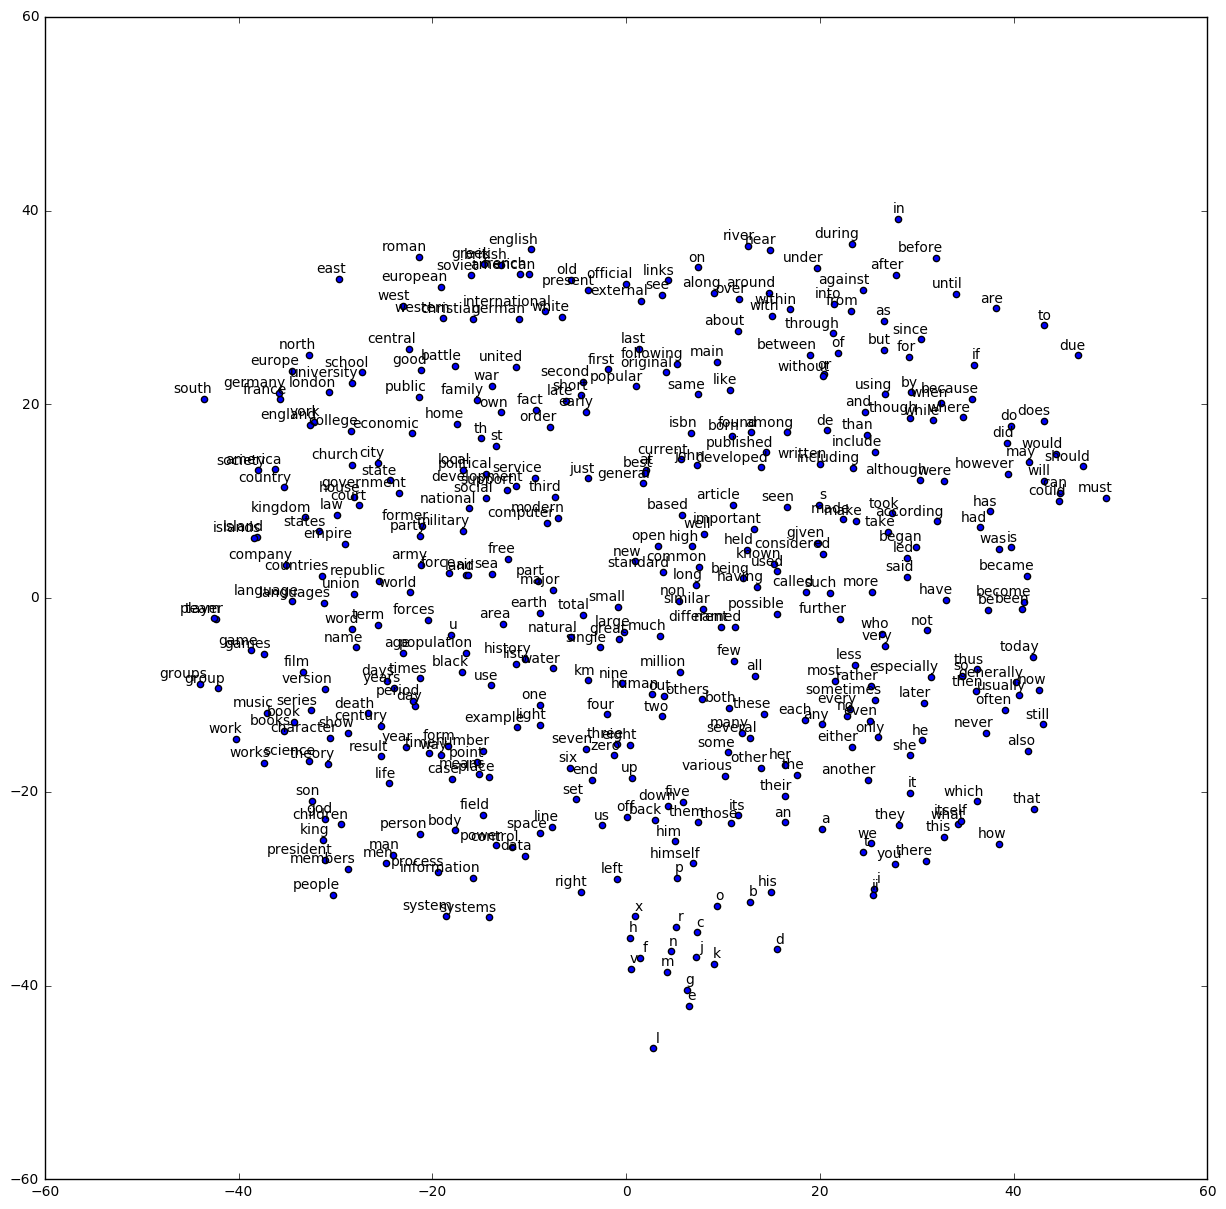

In [14]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [56]:
data_index = 0

def generate_batch(batch_size, skip_window):
    global data_index
    #assert skip_window % 2 == 1

    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
    batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    for i in range(batch_size):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
    
        col_idx = 0
        for j in range(span):
            if j ==span//2:
                continue
            batch[i,col_idx] = buffer[j]
            col_idx +=1
        labels[i,0] = buffer[target]
    
    
        buffer.append(data[data_index])
        data_index = (data_index +1) % len(data)
        
    
    assert batch.shape[0]==batch_size and batch.shape[1]== span -1

    return batch,labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in [1,2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, skip_window=skip_window)
    print('    batch:', [reverse_dictionary[bi[0]] for bi in batch])
    print('    batch:', [reverse_dictionary[bi[1]] for bi in batch])    
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    batch: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [45]:

num_steps = 100001

if __name__ == '__main__':
    batch_size = 128
    embedding_size = 128 # Dimension of the embedding vector.
    skip_window = 1 # How many words to consider left and right.
    num_skips = 2 # How many times to reuse an input to generate a label.
    # We pick a random validation set to sample nearest neighbors. here we limit the
    # validation samples to the words that have a low numeric ID, which by
    # construction are also the most frequent.
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100 # Only pick dev samples in the head of the distribution.
    # pick 16 samples from 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))
    num_sampled = 64 # Number of negative examples to sample.

    graph = tf.Graph()

    with graph.as_default(), tf.device('/cpu:0'):

        # Input data.
        train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # Variables.
        # embedding, vector for each word in the vocabulary
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
        softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Model.
        # Look up embeddings for inputs.
        # this might efficiently find the embeddings for given ids (traind dataset)
        # manually doing this might not be efficient given there are 50000 entries in embeddings
        embeds = None
        for i in range(2*skip_window):
            embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
            print('embedding %d shape: %s'%(i,embedding_i.get_shape().as_list()))
            emb_x,emb_y = embedding_i.get_shape().as_list()
            if embeds is None:
                embeds = tf.reshape(embedding_i,[emb_x,emb_y,1])
            else:
                embeds = tf.concat(2,[embeds,tf.reshape(embedding_i,[emb_x,emb_y,1])])

        assert embeds.get_shape().as_list()[2]==2*skip_window
        print("Concat embedding size: %s"%embeds.get_shape().as_list())
        avg_embed =  tf.reduce_mean(embeds,2,keep_dims=False)
        print("Avg embedding size: %s"%avg_embed.get_shape().as_list())

        '''embedding_0 = tf.nn.embedding_lookup(embeddings, train_dataset[:,0])
        embedding_1 = tf.nn.embedding_lookup(embeddings, train_dataset[:,1])
        avg_embed =  (embedding_0+embedding_1)/2.0
        print("Avg embedding size: %s"%avg_embed.get_shape().as_list())'''

        # Compute the softmax loss, using a sample of the negative labels each time.
        # inputs are embeddings of the train words
        # with this loss we optimize weights, biases, embeddings

        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, avg_embed,
                               train_labels, num_sampled, vocabulary_size))

        # Optimizer.
        # Note: The optimizer will optimize the softmax_weights AND the embeddings.
        # This is because the embeddings are defined as a variable quantity and the
        # optimizer's `minimize` method will by default modify all variable quantities
        # that contribute to the tensor it is passed.
        # See docs on `tf.train.Optimizer.minimize()` for more details.
        # Adagrad is required because there are too many things to optimize
        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

        # Compute the similarity between minibatch examples and all embeddings.
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_batch(batch_size, skip_window)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        final_embeddings = normalized_embeddings.eval()

embedding 0 shape: [128, 128]
embedding 1 shape: [128, 128]
Concat embedding size: [128, 128, 2]
Avg embedding size: [128, 128]
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.533465
Nearest to about: burgesses, blink, wr, diseased, younger, swampy, dysprosium, arise,
Nearest to these: lottery, distal, thoughts, sas, counterculture, backdrop, phoned, perform,
Nearest to d: lion, novgorod, allison, karnataka, naiste, tron, programming, chios,
Nearest to was: ease, classroom, bolger, dunsany, lipid, zamora, rogues, bijelo,
Nearest to have: mists, cornwell, lms, packing, perfection, fijian, overlord, kropotkin,
Nearest to four: org, wavefunction, enraged, atoms, transmits, biomass, ganglia, nova,
Nearest to other: sail, versatile, badminton, vest, interactionism, significand, cpr, bystander,
Nearest to he: bundles, lanka, entombed, eaters, nadia, famines, concordat, synagogue,
Nearest to square: accorded, restaurants, riso, i

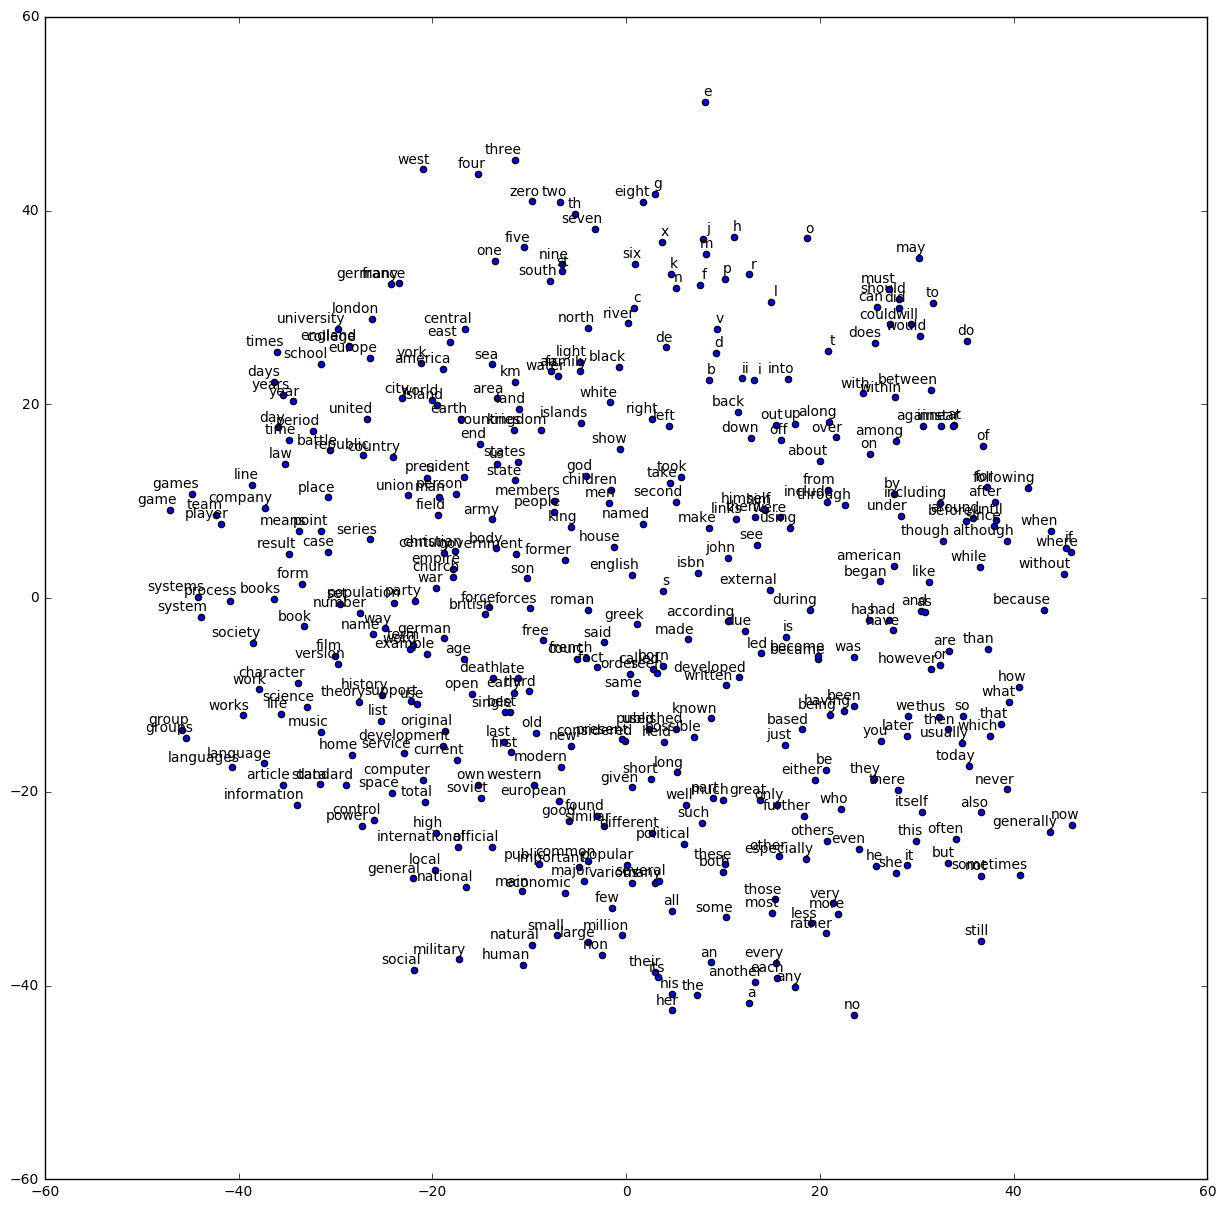

In [47]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)